In [1]:
import os
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import bson
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
INPUT_PATH = 'Data'
CATEGORY_NAMES_DF = pd.read_csv(os.path.join(INPUT_PATH, 'category_names.csv'))
TRAIN_DB = bson.decode_file_iter(open(os.path.join(INPUT_PATH, 'train.bson'), 'rb'))
TEST_DB = bson.decode_file_iter(open(os.path.join(INPUT_PATH, 'test.bson'), 'rb'))

In [3]:
for item in TRAIN_DB:
    break
print(type(item), list(item.keys()))
print(item['_id'], len(item['imgs']), item['category_id'],)

<class 'dict'> ['_id', 'imgs', 'category_id']
0 1 1000010653


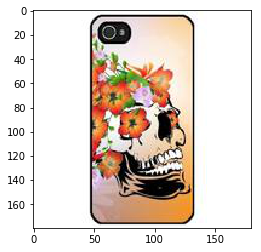

In [4]:
def decode(data):
    arr = np.asarray(bytearray(data), dtype=np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

import io
from PIL import Image

def decode_pil(data):
    return Image.open(io.BytesIO(data))

for img_dict in item['imgs']:
    img = decode(img_dict['picture'])
    plt.figure()
    plt.imshow(img)

In [5]:
level_tags = CATEGORY_NAMES_DF.columns[1:]
CATEGORY_NAMES_DF[CATEGORY_NAMES_DF['category_id'] == item['category_id']][level_tags]

category_level1       category_level2  \
5055  TELEPHONIE - GPS  ACCESSOIRE TELEPHONE   

                         category_level3  
5055  COQUE TELEPHONE - BUMPER TELEPHONE

In [6]:
# Method to compose a single image from 1 - 4 images
def decode_images(item_imgs):
    nx = 2 if len(item_imgs) > 1 else 1
    ny = 2 if len(item_imgs) > 2 else 1
    composed_img = np.zeros((ny * 180, nx * 180, 3), dtype=np.uint8)
    for i, img_dict in enumerate(item_imgs):
        img = decode(img_dict['picture'])
        h, w, _ = img.shape        
        xstart = (i % nx) * 180
        xend = xstart + w
        ystart = (i // nx) * 180
        yend = ystart + h
        composed_img[ystart:yend, xstart:xend] = img
    return composed_img


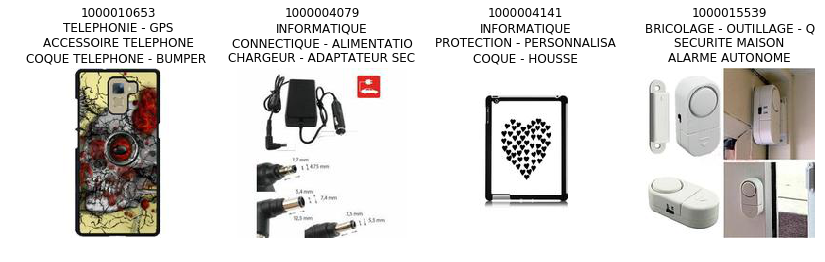

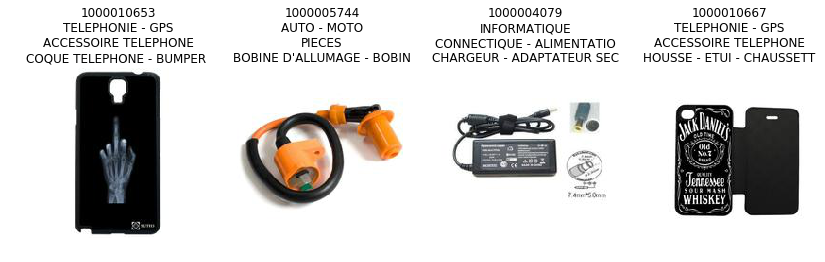

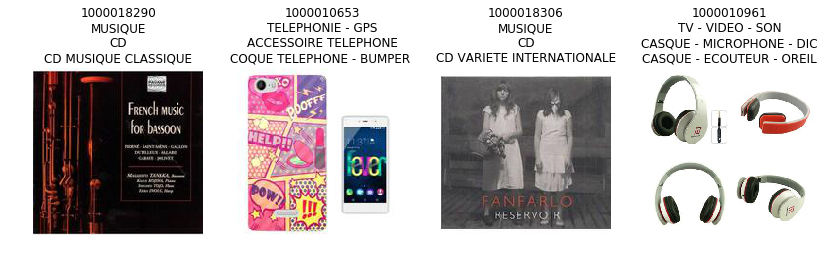

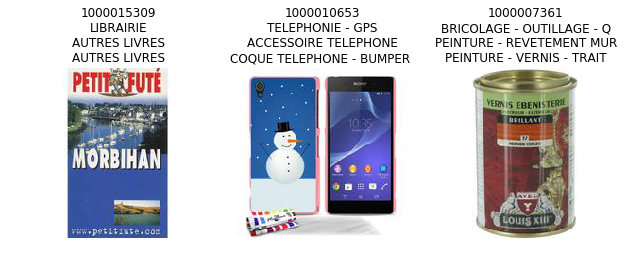

In [7]:
max_counter = 15
counter = 0
n = 4
for item in TRAIN_DB:    
    if counter % n == 0:
        plt.figure(figsize=(14, 6))
    
    mask = CATEGORY_NAMES_DF['category_id'] == item['category_id']    
    plt.subplot(1, n, counter % n + 1)
    cat_levels = CATEGORY_NAMES_DF[mask][level_tags].values.tolist()[0]
    cat_levels = [c[:25] for c in cat_levels]
    title = str(item['category_id']) + '\n'
    title += '\n'.join(cat_levels)
    plt.title(title)
    plt.imshow(decode_images(item['imgs']))
    plt.axis('off')
    
    counter += 1
    if counter == max_counter:
        break

In [8]:
for item in TEST_DB:
    break
print(type(item), list(item.keys()))
print(item['_id'], len(item['imgs']))

<class 'dict'> ['_id', 'imgs']
10 3


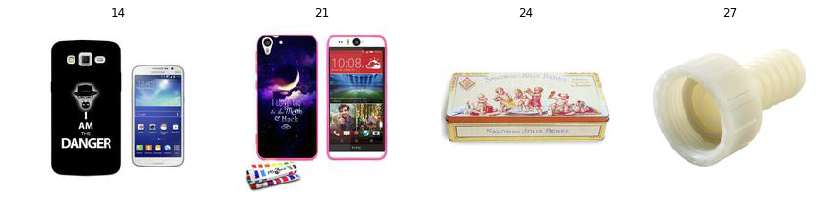

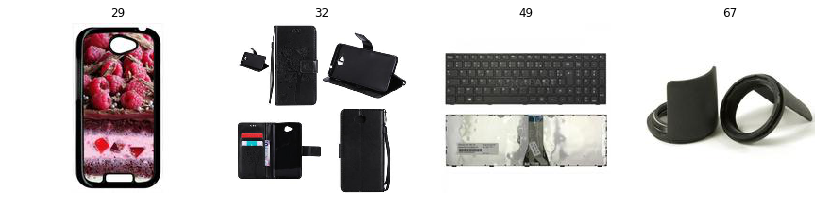

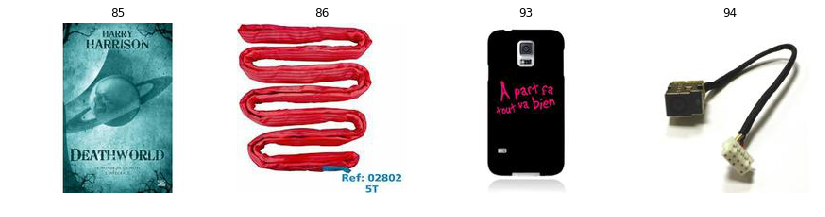

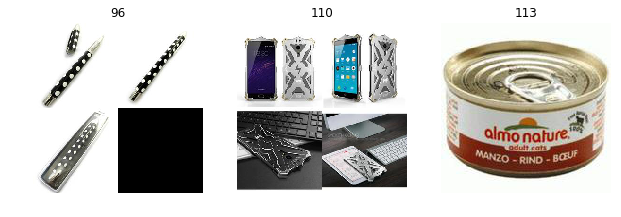

In [9]:
max_counter = 15
counter = 0
n = 4
for item in TEST_DB:    
    if counter % n == 0:
        plt.figure(figsize=(14, 6))
    
    plt.subplot(1, n, counter % n + 1)
    title = str(item['_id'])
    plt.title(title)
    plt.imshow(decode_images(item['imgs']))
    plt.axis('off')
    
    counter += 1
    if counter == max_counter:
        break

In [10]:
import struct
from tqdm import tqdm_notebook

num_dicts = 7069896 # according to data page
length_size = 4
IDS_MAPPING = {}

with open(os.path.join(INPUT_PATH, 'train.bson'), 'rb') as f, tqdm_notebook(total=num_dicts) as bar:
    item_data = []
    offset = 0
    while True:        
        bar.update()
        f.seek(offset)
        
        item_length_bytes = f.read(length_size)     
        if len(item_length_bytes) == 0:
            break                
        # Decode item length:
        length = struct.unpack("<i", item_length_bytes)[0]
        
        f.seek(offset)
        item_data = f.read(length)
        assert len(item_data) == length, "%i vs %i" % (len(item_data), length)
        
        # Check if we can decode
        item = bson.BSON.decode(item_data)
        
        IDS_MAPPING[item['_id']] = (offset, length)        
        offset += length            
            
def get_item(item_id):
    assert item_id in IDS_MAPPING
    with open(os.path.join(INPUT_PATH, 'train.bson'), 'rb') as f:
        offset, length = IDS_MAPPING[item_id]
        f.seek(offset)
        item_data = f.read(length)
        return bson.BSON.decode(item_data)

A Jupyter Widget

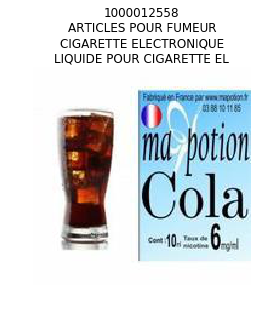

In [13]:
item = get_item(964)

mask = CATEGORY_NAMES_DF['category_id'] == item['category_id']    
cat_levels = CATEGORY_NAMES_DF[mask][level_tags].values.tolist()[0]
cat_levels = [c[:25] for c in cat_levels]
title = str(item['category_id']) + '\n'
title += '\n'.join(cat_levels)
plt.title(title)
plt.imshow(decode_images(item['imgs']))
_ = plt.axis('off')

In [13]:
print("Unique categories: ", len(CATEGORY_NAMES_DF['category_id'].unique()))
print("Unique level 1 categories: ", len(CATEGORY_NAMES_DF['category_level1'].unique()))
print("Unique level 2 categories: ", len(CATEGORY_NAMES_DF['category_level2'].unique()))
print("Unique level 3 categories: ", len(CATEGORY_NAMES_DF['category_level3'].unique()))

Unique categories:  5270
Unique level 1 categories:  49
Unique level 2 categories:  483
Unique level 3 categories:  5263


In [14]:
gb = CATEGORY_NAMES_DF.groupby('category_level3')
cnt = gb.count()
cnt[cnt['category_id'] > 1]

category_id  category_level1  \
category_level3                                                    
CONFORT URINAIRE                              2                2   
FONTAINE A EAU                                2                2   
FUSIBLE                                       2                2   
GUIDON                                        2                2   
PELUCHE                                       2                2   
PROTEGE ECRAN - FILM DE PROTECTION            2                2   
VOITURE                                       2                2   

                                    category_level2  
category_level3                                      
CONFORT URINAIRE                                  2  
FONTAINE A EAU                                    2  
FUSIBLE                                           2  
GUIDON                                            2  
PELUCHE                                           2  
PROTEGE ECRAN - FILM DE PROTECTION                2  
VOITURE                                           2

In [15]:
gb.get_group(cnt[cnt['category_id'] > 1].index.values[0])

category_id category_level1  \
4018   1000004394   PARAPHARMACIE   
4041   1000012827   PARAPHARMACIE   

                                    category_level2   category_level3  
4018  COMPLEMENTS ALIMENTAIRES - THE INFUSION SANTE  CONFORT URINAIRE  
4041  TRAITEMENTS LIBRE SERVICE - SOINS PATHOLOGIES  CONFORT URINAIRE

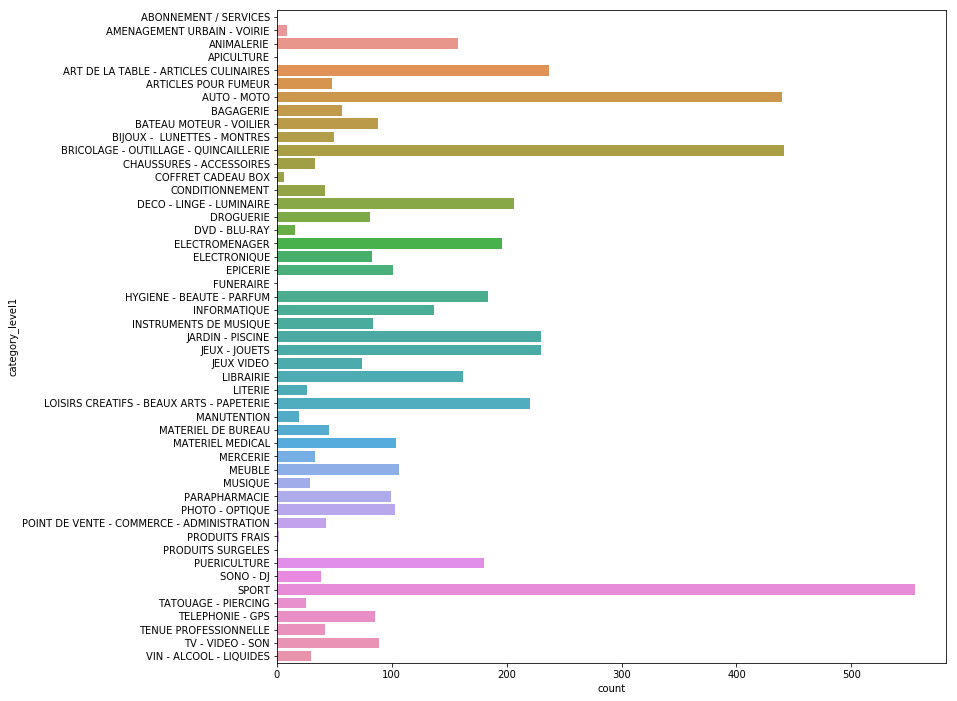

In [40]:
plt.figure(figsize=(12,12))
_ = sns.countplot(y=CATEGORY_NAMES_DF['category_level1'])

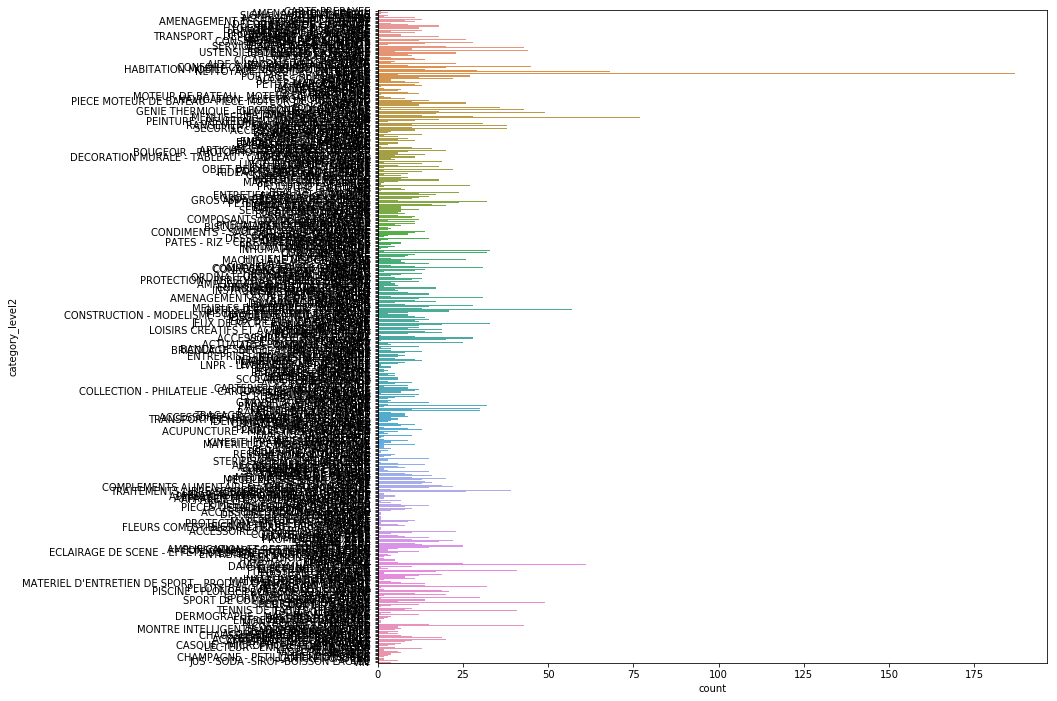

In [14]:
plt.figure(figsize=(12,12))
_ = sns.countplot(y=CATEGORY_NAMES_DF['category_level2'])

In [39]:
CATEGORY_NAMES_DF['category_level1'].value_counts

<bound method IndexOpsMixin.value_counts of 0             ABONNEMENT / SERVICES
1       AMENAGEMENT URBAIN - VOIRIE
2       AMENAGEMENT URBAIN - VOIRIE
3       AMENAGEMENT URBAIN - VOIRIE
4       AMENAGEMENT URBAIN - VOIRIE
5       AMENAGEMENT URBAIN - VOIRIE
6       AMENAGEMENT URBAIN - VOIRIE
7       AMENAGEMENT URBAIN - VOIRIE
8       AMENAGEMENT URBAIN - VOIRIE
9       AMENAGEMENT URBAIN - VOIRIE
10                       ANIMALERIE
11                       ANIMALERIE
12                       ANIMALERIE
13                       ANIMALERIE
14                       ANIMALERIE
15                       ANIMALERIE
16                       ANIMALERIE
17                       ANIMALERIE
18                       ANIMALERIE
19                       ANIMALERIE
20                       ANIMALERIE
21                       ANIMALERIE
22                       ANIMALERIE
23                       ANIMALERIE
24                       ANIMALERIE
25                       ANIMALERIE
26                  

In [43]:
cat_level1_counts = CATEGORY_NAMES_DF.groupby('category_level1')['category_level1'].count()
print(cat_level1_counts.describe())
print("Level 1 the most frequent category: ", cat_level1_counts.argmax())

count     49.00000
mean     107.55102
std      119.12547
min        1.00000
25%       30.00000
50%       81.00000
75%      158.00000
max      555.00000
Name: category_level1, dtype: float64
Level 1 the most frequent category:  SPORT


In [41]:
cat_level2_counts = CATEGORY_NAMES_DF.groupby('category_level2')['category_level2'].count()
print(cat_level2_counts.describe())
print("Level 2 the most frequent category: ", cat_level2_counts.argmax())

count    483.000000
mean      10.910973
std       13.035315
min        1.000000
25%        4.000000
50%        8.000000
75%       13.000000
max      187.000000
Name: category_level2, dtype: float64
Level 2 the most frequent category:  PIECES


In [42]:
cat_level3_counts = CATEGORY_NAMES_DF.groupby('category_level3')['category_level3'].count()
print(cat_level3_counts.describe())
print("Level 3 the most frequent category: ", cat_level3_counts.argmax())

count    5263.000000
mean        1.001330
std         0.036449
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: category_level3, dtype: float64
Level 3 the most frequent category:  CONFORT URINAIRE


In [17]:
from tqdm import tqdm_notebook

num_dicts = 7069896 # according to data page
prod_to_category = [None] * num_dicts

with tqdm_notebook(total=num_dicts) as bar:        
    TRAIN_DB = bson.decode_file_iter(open(os.path.join(INPUT_PATH, 'train.bson'), 'rb'))

    for i, item in enumerate(TRAIN_DB):
        bar.update()
        prod_to_category[i] = (item['_id'], item['category_id'])

A Jupyter Widget

In [19]:
TRAIN_CATEGORIES_DF = pd.DataFrame(prod_to_category, columns=['_id', 'category_id'])
TRAIN_CATEGORIES_DF.head()

_id  category_id
0    0   1000010653
1    1   1000010653
2    2   1000004079
3    3   1000004141
4    4   1000015539

In [20]:
print("Unique categories: %i in %i entries" % (len(TRAIN_CATEGORIES_DF['category_id'].unique()), len(TRAIN_CATEGORIES_DF)))

Unique categories: 5270 in 7069896 entries


In [21]:
train_categories_gb = TRAIN_CATEGORIES_DF.groupby('category_id')
train_categories_count = train_categories_gb['category_id'].count()
print(train_categories_count.describe())

count     5270.000000
mean      1341.536243
std       4941.011223
min         12.000000
25%         69.000000
50%        200.000000
75%        718.500000
max      79640.000000
Name: category_id, dtype: float64


In [22]:
most_freq_cats = train_categories_count[train_categories_count == train_categories_count.max()]
less_freq_cats = train_categories_count[train_categories_count == train_categories_count.min()]

print("Most frequent category: ", CATEGORY_NAMES_DF[CATEGORY_NAMES_DF['category_id'].isin(most_freq_cats.index)].values)
print("Less frequent category: ", CATEGORY_NAMES_DF[CATEGORY_NAMES_DF['category_id'].isin(less_freq_cats.index)].values)

Most frequent category:  [[1000018296 'MUSIQUE' 'CD' 'CD POP ROCK - CD ROCK INDE']]
Less frequent category:  [[1000017266 'APICULTURE' "OUTILS DE L'APICULTEUR"
  'CHASSE-ABEILLES - PIEGE INSECTES - BOUCHON PIEGE']
 [1000022465 'BATEAU MOTEUR - VOILIER' 'ELECTRICITE'
  'CONVERTISSEUR DE TENSION']
 [1000017559 'BATEAU MOTEUR - VOILIER'
  'PIECE MOTEUR DE BATEAU - PIECE MOTEUR DE HORS BORD'
  'ECHAPEMENT - VENTILATION']
 [1000015609 'CHAUSSURES - ACCESSOIRES' 'ACCESSOIRES CHAUSSURES'
  'ESSUIE-BOTTES - LAVE-BOTTES']
 [1000008633 'CONDITIONNEMENT' 'CALAGE - PROTECTION' 'COUSSIN GONFLABLE']
 [1000012168 'DROGUERIE' 'COMBUSTIBLE' 'CHARBON DE BOIS']
 [1000012287 'DROGUERIE' "MATERIEL D'ENTRETIEN" 'PINCE A DECHETS']
 [1000003589 'ELECTROMENAGER' 'ENTRETIEN DES SOLS - MAISON' 'CIREUSE']
 [1000013297 'ELECTRONIQUE' 'CAPTEURS' 'SYSTEME DE SURVEILLANCE DE NIVEAU']
 [1000000896 'EPICERIE' 'CONSERVE DE LEGUME' 'POIVRON EN CONSERVE']
 [1000016613 'HYGIENE - BEAUTE - PARFUM' 'CAPILLAIRE'
  'PASSE A ME

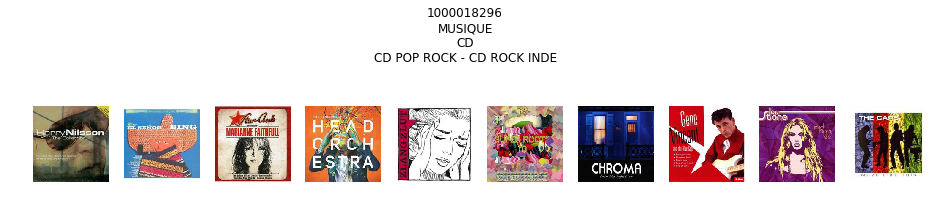

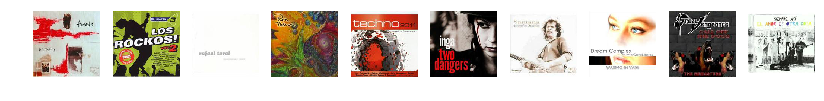

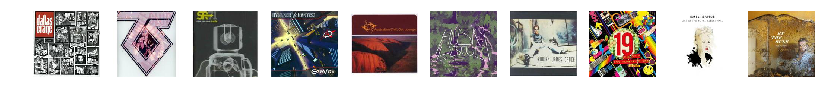

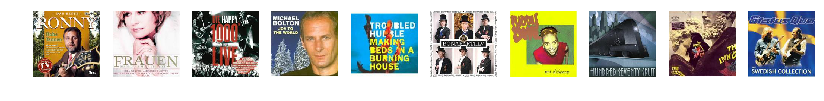

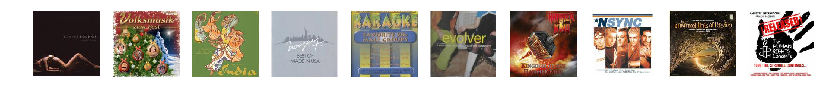

In [23]:
most_freq_cat = most_freq_cats.index[0]

plt.figure(figsize=(16, 4))
mask = CATEGORY_NAMES_DF['category_id'] == most_freq_cat    
cat_levels = CATEGORY_NAMES_DF[mask][level_tags].values.tolist()[0]
title = str(most_freq_cat) + '\n'
title += '\n'.join(cat_levels)
plt.suptitle(title)

most_freq_cat_ids = train_categories_gb.get_group(most_freq_cat)['_id']
max_counter = 50
counter = 0
n = 10
for item_id in most_freq_cat_ids.values[:max_counter]:    
    if counter > 0 and counter % n == 0:
        plt.figure(figsize=(14, 6))
    
    item = get_item(item_id)
    
    mask = CATEGORY_NAMES_DF['category_id'] == item['category_id']    
    plt.subplot(1, n, counter % n + 1)
    plt.imshow(decode_images(item['imgs']))
    plt.axis('off')
    
    counter += 1
    if counter == max_counter:
        break

/Users/anilkumar/Anils/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


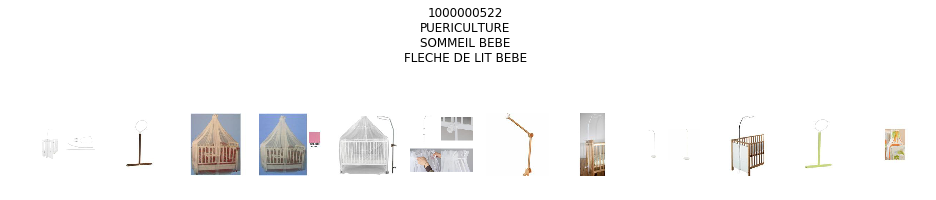

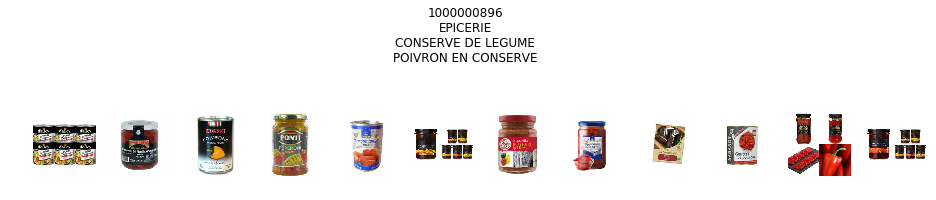

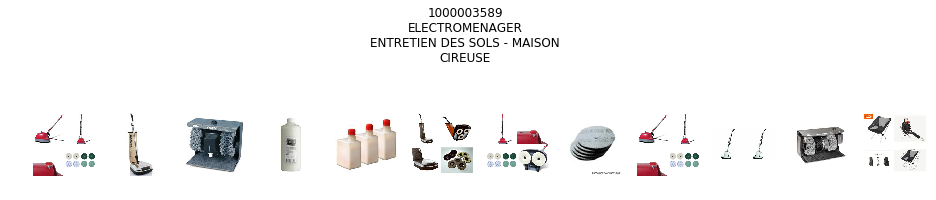

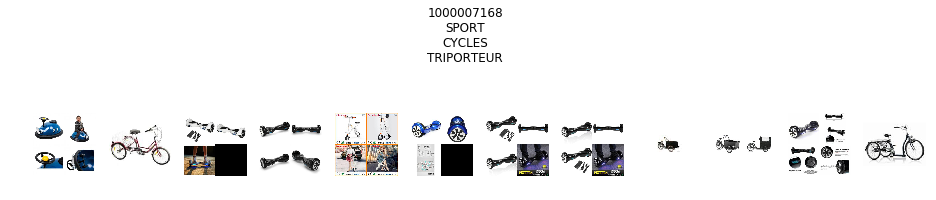

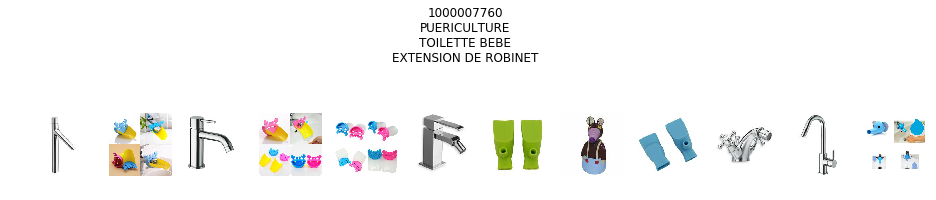

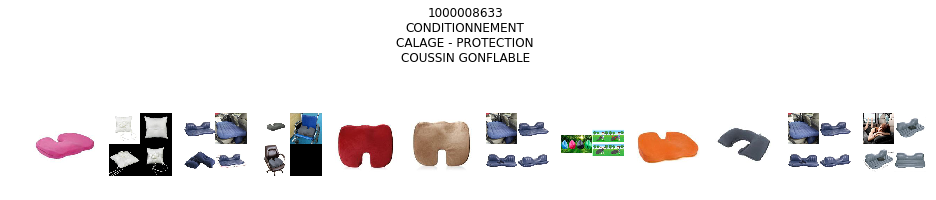

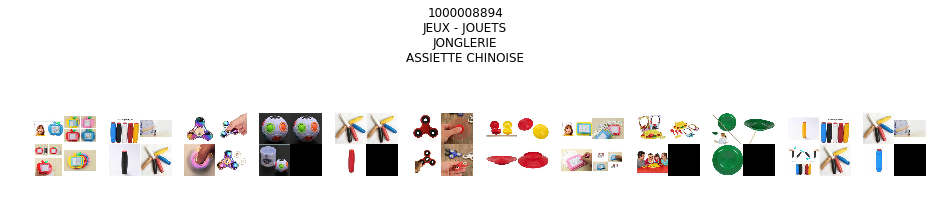

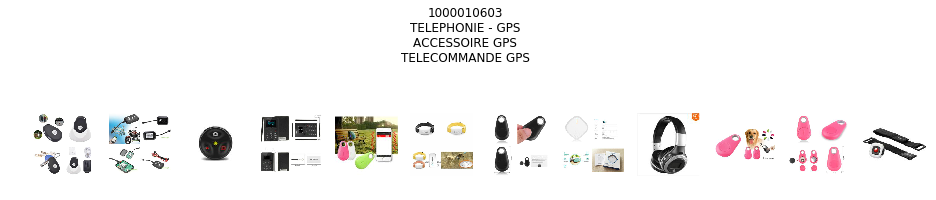

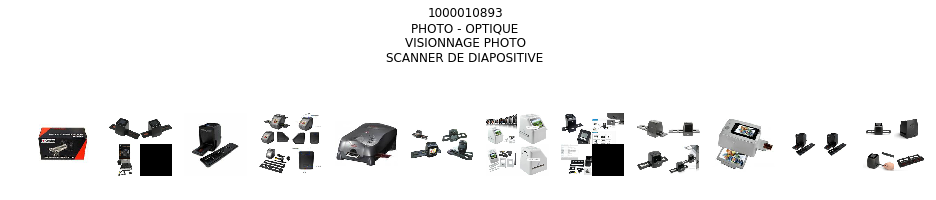

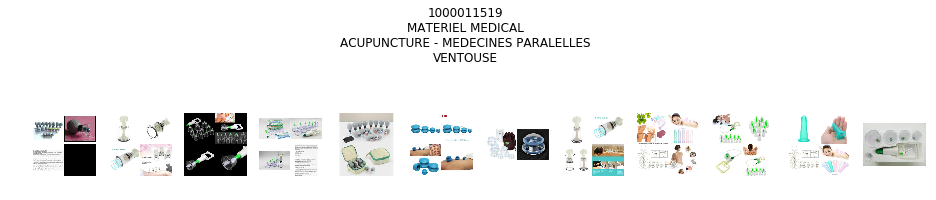

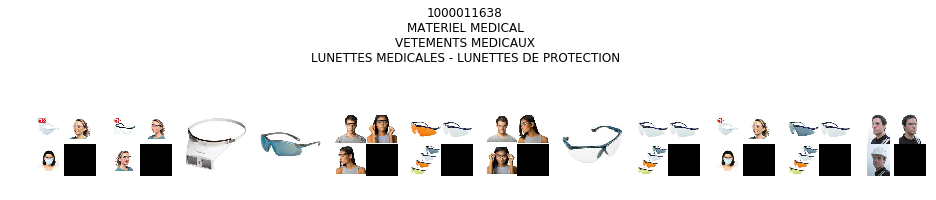

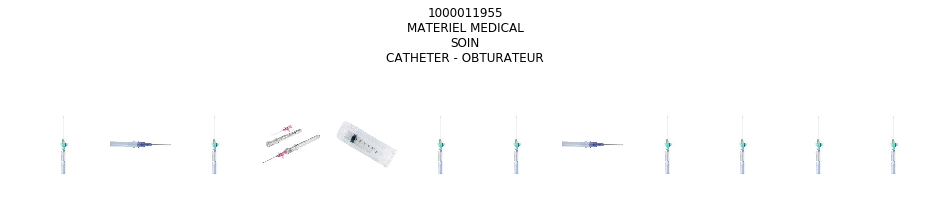

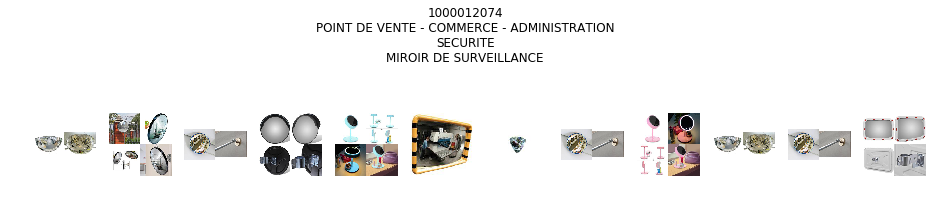

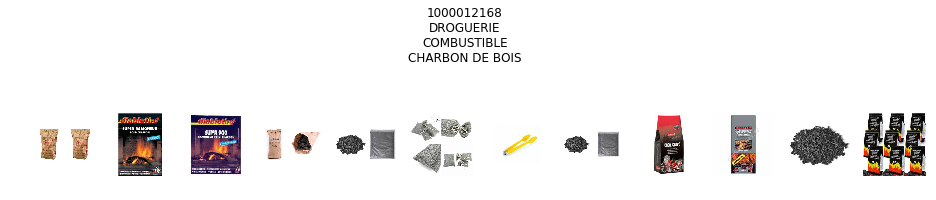

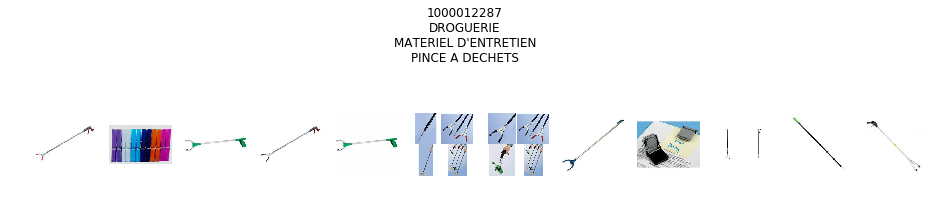

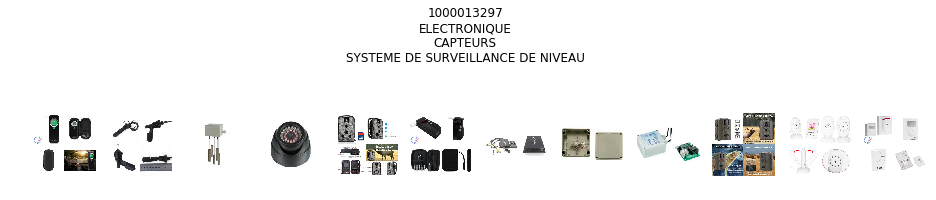

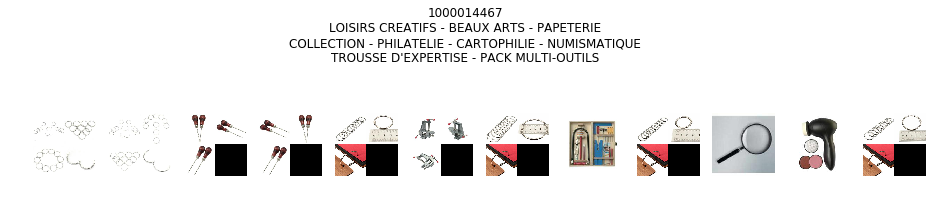

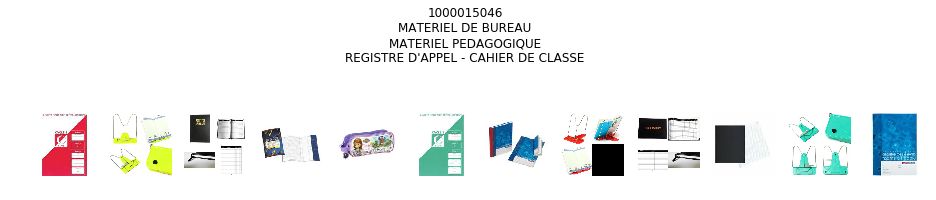

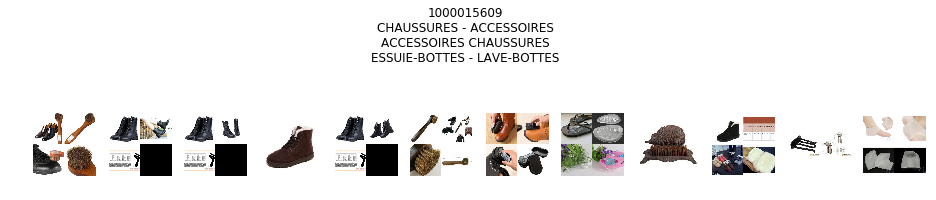

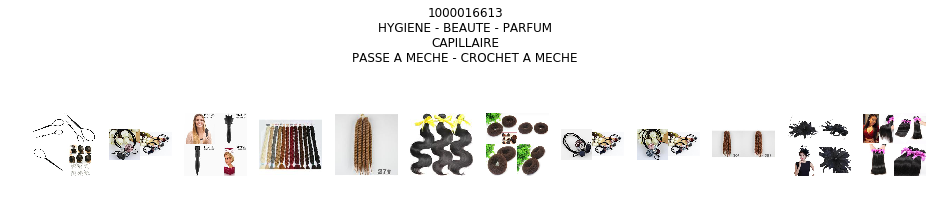

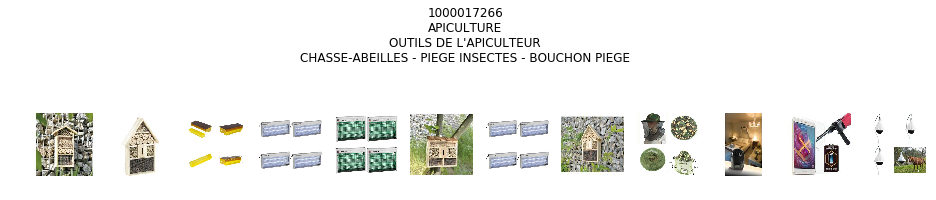

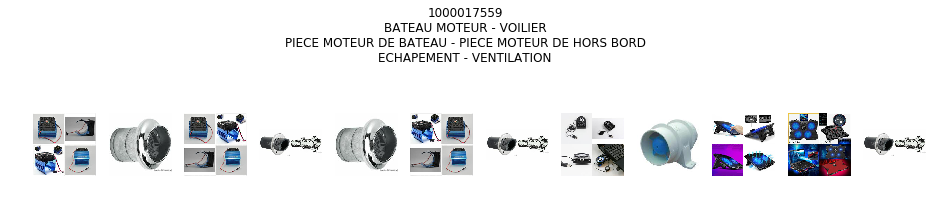

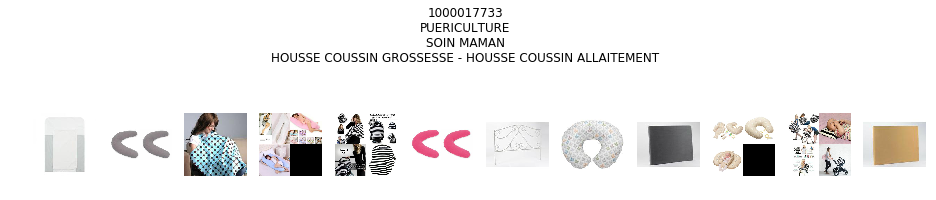

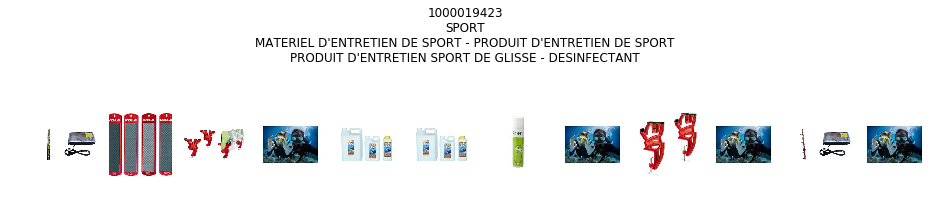

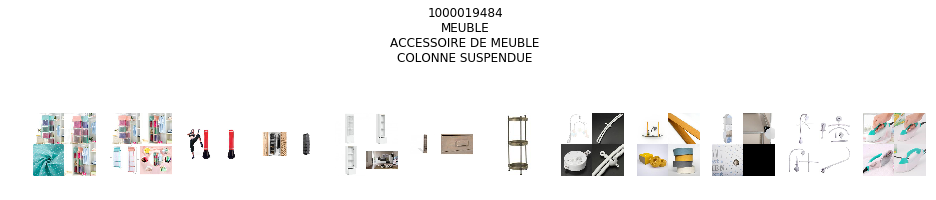

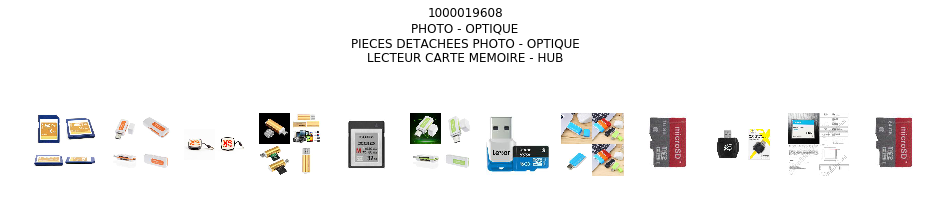

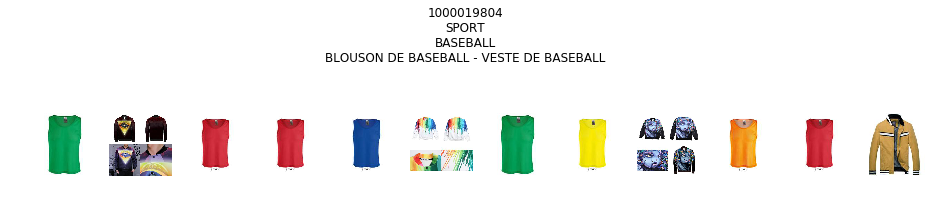

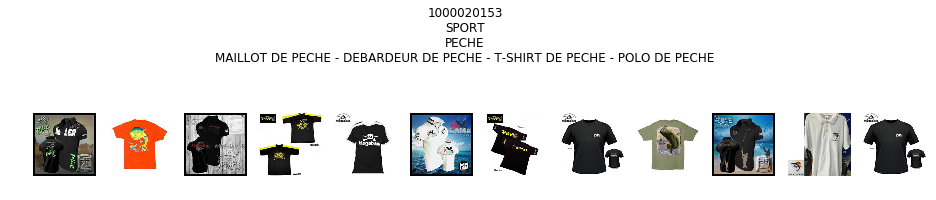

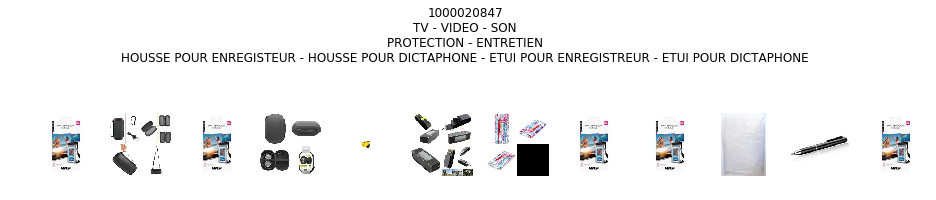

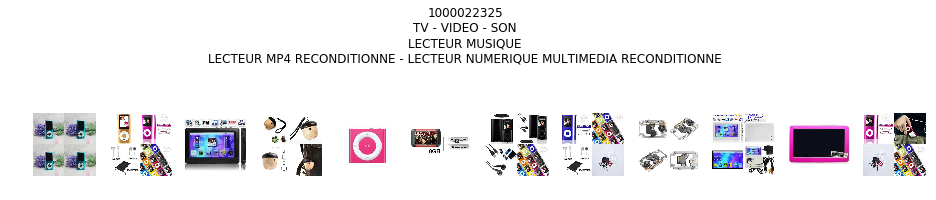

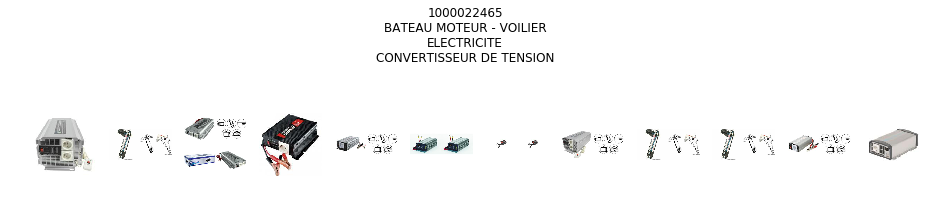

In [44]:
for less_freq_cat in less_freq_cats.index:
    less_freq_cat_ids = train_categories_gb.get_group(less_freq_cat)['_id']
    counter = 0
    n = 12
    
    plt.figure(figsize=(16, 4))
    mask = CATEGORY_NAMES_DF['category_id'] == less_freq_cat    
    cat_levels = CATEGORY_NAMES_DF[mask][level_tags].values.tolist()[0]
    title = str(less_freq_cat) + '\n'
    title += '\n'.join(cat_levels)
    plt.suptitle(title)

    for item_id in less_freq_cat_ids.values:    
        if counter > 0 and counter % n == 0:
            plt.figure(figsize=(16, 4))

        item = get_item(item_id)

        mask = CATEGORY_NAMES_DF['category_id'] == item['category_id']    
        plt.subplot(1, n, counter % n + 1)
        plt.imshow(decode_images(item['imgs']))
        plt.axis('off')

        counter += 1        

In [47]:
len(train_categories_count.values)

5270

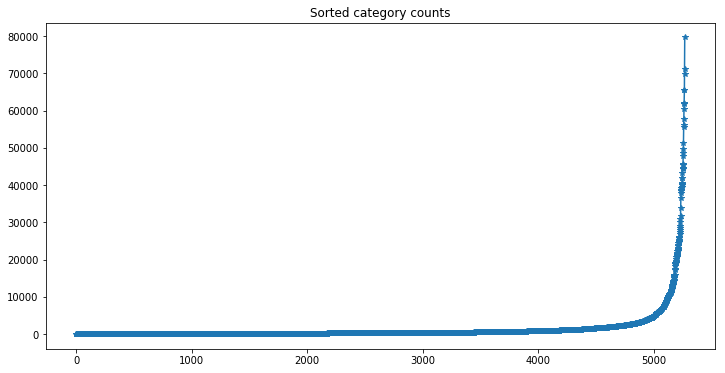

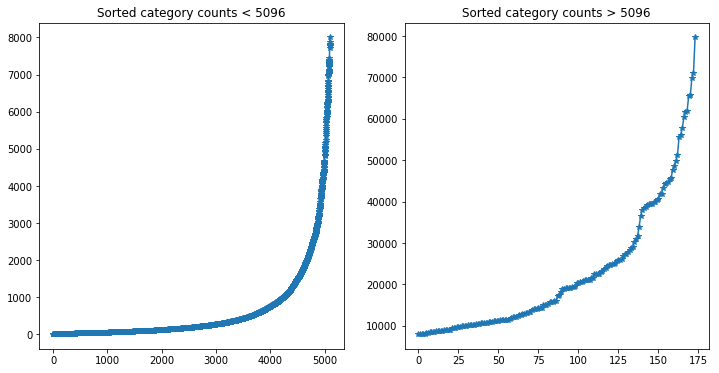

In [25]:
sorted_train_categories_count = sorted(train_categories_count.values)
index_8000 = np.where(np.array(sorted_train_categories_count) > 8000)[0][0]

plt.figure(figsize=(12, 6))
plt.title("Sorted category counts")
_ = plt.plot(sorted_train_categories_count, '*-')

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Sorted category counts < %i" % index_8000)
_ = plt.plot(sorted_train_categories_count[:index_8000], '*-')

plt.subplot(122)
plt.title("Sorted category counts > %i" % index_8000)
_ = plt.plot(sorted_train_categories_count[index_8000:], '*-')

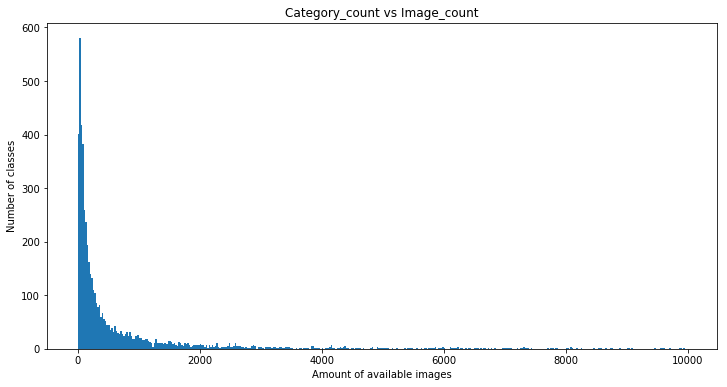

In [26]:
plt.figure(figsize=(12, 6))
plt.title('Category_count vs Image_count')
bin_size = 25
plt.hist(train_categories_count, bins=range(0, int(1e4), bin_size))
plt.xlabel('Amount of available images')
_ = plt.ylabel('Number of classes')

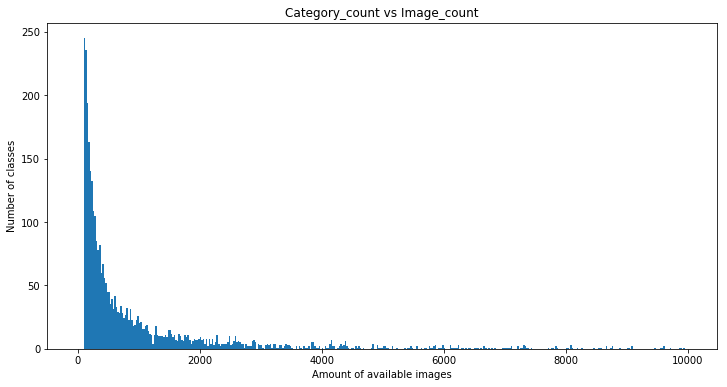

In [27]:
train_categories_count_25upper = train_categories_gb['category_id'].count()[train_categories_gb['category_id'].count()>100] 
plt.figure(figsize=(12, 6))
plt.title('Category_count vs Image_count')
bin_size = 25
plt.hist(train_categories_count_25upper, bins=range(0, int(1e4), bin_size))
plt.xlabel('Amount of available images')
_ = plt.ylabel('Number of classes')

In [36]:
train_categories_gb['category_id'].count()[train_categories_gb['category_id'].count()>5000].sort_values(ascending=False)

category_id
1000018296    79640
1000011423    71116
1000011427    69784
1000014202    65642
1000015309    65435
1000004085    61942
1000010653    61688
1000018290    60332
1000018294    57748
1000008094    56192
1000004079    55656
1000005509    51332
1000015912    49780
1000010635    48488
1000011349    47691
1000010683    45756
1000018286    45353
1000012991    44647
1000003796    44502
1000010647    44332
1000012993    43368
1000010170    41933
1000004141    41812
1000018246    40546
1000005956    40407
1000010100    39988
1000010108    39932
1000002328    39377
1000010722    39361
1000010110    39306
              ...  
1000014115     5920
1000014038     5868
1000018386     5858
1000014285     5858
1000003228     5839
1000018282     5825
1000014243     5824
1000014213     5776
1000015468     5768
1000006010     5764
1000005890     5712
1000017901     5692
1000010082     5628
1000010928     5573
1000008952     5566
1000012857     5498
1000012900     5457
1000014267     5452
10000089

In [35]:
train_categories_gb['category_id'].count().sort_values()

category_id
1000019804       12
1000011638       12
1000012287       12
1000000522       12
1000011519       12
1000020847       12
1000010893       12
1000010603       12
1000000896       12
1000013297       12
1000020153       12
1000017733       12
1000022325       12
1000014467       12
1000008633       12
1000019608       12
1000017559       12
1000003589       12
1000007760       12
1000015046       12
1000019484       12
1000019423       12
1000007168       12
1000015609       12
1000016613       12
1000008894       12
1000011955       12
1000017266       12
1000022465       12
1000012168       12
              ...  
1000010110    39306
1000010722    39361
1000002328    39377
1000010108    39932
1000010100    39988
1000005956    40407
1000018246    40546
1000004141    41812
1000010170    41933
1000012993    43368
1000010647    44332
1000003796    44502
1000012991    44647
1000018286    45353
1000010683    45756
1000011349    47691
1000010635    48488
1000015912    49780
10000055